In [2]:
import sys
import os

# Get the root directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# Add the root directory to the Python path
sys.path.append(root_dir)

# Load libraries and set device engine

In [3]:
import torch
from kan import *
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset
import cv2
import gc
import torch.optim as optim
from torch.optim.lr_scheduler import OneCycleLR
import time
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tqdm import tqdm

In [4]:
if torch.cuda.is_available():
  device = torch.device("cuda")
else:
  device = torch.device("cpu")

print(device)

cuda


# Load Dataset and split data

In [5]:
SEED = 381
# SET RANDOM SEED FOR REPRODUCIBILITY
torch.manual_seed(SEED)
random.seed(SEED)
np.random.seed(SEED)

In [6]:
df = pd.read_csv(f"data/california_housing.csv")

In [6]:
df

,MedInc,HouseAge,AveRooms,AveBedrms,Population,AveOccup,Latitude,Longitude,MedHouseVal
0,8.3252,41.0,6.984127,1.023810,322.0,2.555556,37.88,-122.23,4.526
1,8.3014,21.0,6.238137,0.971880,2401.0,2.109842,37.86,-122.22,3.585
2,7.2574,52.0,8.288136,1.073446,496.0,2.802260,37.85,-122.24,3.521
3,5.6431,52.0,5.817352,1.073059,558.0,2.547945,37.85,-122.25,3.413
4,3.8462,52.0,6.281853,1.081081,565.0,2.181467,37.85,-122.25,3.422
...,...,...,...,...,...,...,...,...,...
20635,1.5603,25.0,5.045455,1.133333,845.0,2.560606,39.48,-121.09,0.781
20636,2.5568,18.0,6.114035,1.315789,356.0,3.122807,39.49,-121.21,0.771
20637,1.7000,17.0,5.205543,1.120092,1007.0,2.325635,39.43,-121.22,0.923
20638,1.8672,18.0,5.329513,1.171920,741.0,2.123209,39.43,-121.32,0.847


In [7]:
# Function to load and preprocess data
def load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=32):
    
    X_train, X_val = train_test_split(df, test_size=0.20, random_state=SEED)
    X_val, X_test = train_test_split(X_val, test_size=0.50, random_state=SEED)
    X_train = X_train.reset_index(drop=True)
    X_val = X_val.reset_index(drop=True)
    X_test = X_test.reset_index(drop=True)
    
    ### X_train
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/train'):
        #Generate thet images
        image_model.fit_transform(X_train, f'{images_folder}/train')
        image_model.saveHyperparameters(f'{images_folder}'+"/model.pkl")
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/train',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)
    
    # Update image paths
    imgs["images"] = images_folder + "/train/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_train], axis=1)

    # Split data
    X_train = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_train = combined_dataset["values"]
        
    ### X_val
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/val'):
        #Generate thet images
        image_model.transform(X_val, f'{images_folder}/val')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/val',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/val/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_val], axis=1)

    # Split data
    X_val = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_val = combined_dataset["values"]
    
    ### X_test
    # Generate the images if the folder does not exist
    if not os.path.exists(f'{images_folder}/test'):
        #Generate thet images
        image_model.transform(X_test, f'{images_folder}/test')
    else:
        print("The images are already generated")

    img_paths = os.path.join(f'{images_folder}/test',problem_type+".csv")

    print(img_paths)
    
    imgs = pd.read_csv(img_paths)

    # Update image paths
    imgs["images"] = images_folder + "/test/" + imgs["images"]

    # Combine datasets
    combined_dataset = pd.concat([imgs, X_test], axis=1)

    # Split data
    X_test = combined_dataset.drop(df.columns[-1], axis=1).drop("values", axis=1)
    y_test = combined_dataset["values"]
    
    # Numerical data
    X_train_num = X_train.drop("images", axis=1)
    X_val_num = X_val.drop("images", axis=1)
    X_test_num = X_test.drop("images", axis=1)

    # Image data
    X_train_img = np.array([cv2.imread(img) for img in X_train["images"]])
    X_val_img = np.array([cv2.imread(img) for img in X_val["images"]])
    X_test_img = np.array([cv2.imread(img) for img in X_test["images"]])

    ## Create a MinMaxScaler object
    scaler = MinMaxScaler()

    ## Scale numerical data
    X_train_num = pd.DataFrame(scaler.fit_transform(X_train_num), columns=X_train_num.columns)
    X_val_num = pd.DataFrame(scaler.transform(X_val_num), columns=X_val_num.columns)
    X_test_num = pd.DataFrame(scaler.transform(X_test_num), columns=X_test_num.columns)

    attributes = len(X_train_num.columns)
    height, width, channels = X_train_img[0].shape
    imgs_shape = (channels, height, width)

    print("Images shape: ", imgs_shape)
    print("Attributes: ", attributes)
    # Convert data to PyTorch tensors
    X_train_num_tensor = torch.as_tensor(X_train_num.values, dtype=torch.float32)
    X_val_num_tensor = torch.as_tensor(X_val_num.values, dtype=torch.float32)
    X_test_num_tensor = torch.as_tensor(X_test_num.values, dtype=torch.float32)
    X_train_img_tensor = torch.as_tensor(X_train_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_val_img_tensor = torch.as_tensor(X_val_img, dtype=torch.float32).permute(0, 3, 1, 2)
    X_test_img_tensor = torch.as_tensor(X_test_img, dtype=torch.float32).permute(0, 3, 1, 2)
    y_train_tensor = torch.as_tensor(y_train.values, dtype=torch.float32).reshape(-1, 1)
    y_val_tensor = torch.as_tensor(y_val.values, dtype=torch.float32).reshape(-1, 1)
    y_test_tensor = torch.as_tensor(y_test.values, dtype=torch.float32).reshape(-1, 1)

    # Normalize to [0, 1]
    X_train_img_tensor = X_train_img_tensor / 255.0
    X_val_img_tensor = X_val_img_tensor / 255.0
    X_test_img_tensor = X_test_img_tensor / 255.0

    # Create DataLoaders
    train_dataset = TensorDataset(X_train_num_tensor, X_train_img_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_num_tensor, X_val_img_tensor, y_val_tensor)
    test_dataset = TensorDataset(X_test_num_tensor, X_test_img_tensor, y_test_tensor)

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, pin_memory=True)

    return train_loader, val_loader, test_loader, attributes, imgs_shape 


In [8]:
batch_size = 32
# Get the shape of the dataframe
num_columns = df.shape[1]

# Calculate number of columns - 1
columns_minus_one = num_columns - 1

# Calculate the square root for image size
import math
image_size = math.ceil(math.sqrt(columns_minus_one))
print(image_size)

3


In [9]:
from TINTOlib.igtd import IGTD
dataset_name = 'california_housing'
#Select the model and the parameters
problem_type = "regression"
image_model = IGTD(problem= problem_type, scale=[image_size,image_size], fea_dist_method='Euclidean', image_dist_method='Euclidean', error='abs', max_step=30000, val_step=300, random_seed=SEED)

name = f"IGTD_{image_size}x{image_size}_fEuclidean_iEuclidean_abs"

#Define the dataset path and the folder where the images will be saved
images_folder = f"HyNNImages/Regression/{dataset_name}/images_{dataset_name}_{name}"

In [10]:
train_loader, val_loader, test_loader, attributes, imgs_shape  = load_and_preprocess_data(images_folder, image_model, problem_type, batch_size=batch_size)

The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/train\regression.csv
The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/val\regression.csv
The images are already generated
HyNNImages/Regression/california_housing/images_california_housing_IGTD_3x3_fEuclidean_iEuclidean_abs/test\regression.csv
Images shape:  (3, 3, 3)
Attributes:  8


In [17]:
class Model1(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model1, self).__init__()
        self.device = device
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        ).to(device)
        
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)
        
        # Calculate the size of the flattened CNN output
        cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)
        
        # Final MLP layers
        self.final_mlp = nn.Sequential(
            nn.Linear(16 + cnn_output_size, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU(),
            nn.Linear(16, 8),
            nn.ReLU(),
            nn.Linear(8, 1)
        ).to(device)
        
    def forward(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        mlp_output = self.mlp_branch(mlp_input)
        cnn_output = self.cnn_branch(cnn_input)
        
        # Concatenate the outputs of CNN and MLP branches
        concat_output = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final MLP layers
        final_output = self.final_mlp(concat_output)
        
        return final_output

In [44]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class Model2(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model2, self).__init__()
        self.device = device
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 16, kernel_size=2, padding=1),
            nn.Flatten()
        ).to(device)
        
        # MLP branch
        self.mlp_branch = nn.Sequential(
            nn.Linear(attributes, 16),
            nn.ReLU(),
            nn.Linear(16, 32),
            nn.ReLU(),
            nn.Linear(32, 16),
            nn.ReLU()
        ).to(device)

        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)

        # Dense layers
        self.final_mlp = nn.Sequential(
            nn.Linear(self.flat_size + 16, 128),
            nn.ReLU(),
            nn.Linear(128, 64),
            nn.ReLU(),
            nn.Linear(64, 32),
            nn.ReLU(),
            nn.Linear(32, 1)
        ).to(device)
        

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_cnn_input = torch.zeros(1, *imgs_shape, device=self.device)
        
        cnn_output = self.cnn_branch(dummy_cnn_input)
        
        return cnn_output.size(1)
    
    def forward(self, mlp_input, cnn_input):
        mlp_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        # CNN branch
        cnn_output = self.cnn_branch(cnn_input)
        
        # MLP branch
        mlp_output = self.mlp_branch(mlp_input)

        # Combine CNN and MLP outputs
        merged = torch.cat((mlp_output, cnn_output), dim=1)
        
        # Final layers
        final_output = self.final_mlp(merged)
        return final_output

In [32]:
import traceback

def try_create_model(model_class, attributes, imgs_shape, device):
    try:
        model = model_class(attributes, imgs_shape, device)
        
        # Test the model with a sample input
        num_input = torch.randn(4, attributes)
        img_input = torch.randn(4, *imgs_shape)
        output = model(num_input, img_input)
        
        print(f"Successfully created and tested {model_class.__name__}")
        
        return model
    except Exception as e:
        print(f"Error creating or testing {model_class.__name__}:")
        traceback.print_exc()
        return None

# Compile and FIT

In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from torch.optim.lr_scheduler import OneCycleLR
import matplotlib.pyplot as plt
import time
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import os

def compile_and_fit(model, train_loader, val_loader, test_loader, dataset_name, model_name, batch_size=32, epochs=100, min_lr=1e-3, max_lr=1, device='cuda', weight_decay=1e-2):
    model = model.to(device)
    loss_fn = nn.MSELoss()
    optimizer = optim.AdamW(model.parameters(), lr=min_lr, weight_decay=weight_decay)
    
    total_steps = epochs * len(train_loader)
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, div_factor=max_lr/min_lr, total_steps=total_steps, pct_start=0.3, final_div_factor=1)
    
    
    best_val_loss = float('inf')
    early_stopping_counter = 0
    early_stopping_patience = 20
    best_model = None
    best_epoch = 0
    warm_up_epochs = epochs*0.3

    history = {'train_loss': [], 'val_loss': [], 'train_mse': [], 'val_mse': [], 'train_rmse': [], 'val_rmse': [], 'learning_rate': [], 'epoch_time': []}

    start_time = time.time()
    
    pbar = tqdm(range(epochs), desc='description', ncols=100)
    for epoch in pbar:
    #for epoch in range(epochs):
        epoch_start_time = time.time()

        model.train()
        train_loss = 0.0
        train_predictions = []
        train_targets = []
        for num_data, img_data, targets in train_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            optimizer.zero_grad()
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
            
            train_loss += loss.item()
            train_predictions.extend(outputs.cpu().detach().numpy())
            train_targets.extend(targets.cpu().numpy())

        model.eval()
        val_loss = 0.0
        val_predictions = []
        val_targets = []
        with torch.no_grad():
            for num_data, img_data, targets in val_loader:
                num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)

                outputs = model(num_data, img_data)
                loss = loss_fn(outputs, targets)
                
                val_loss += loss.item()
                val_predictions.extend(outputs.cpu().numpy())
                val_targets.extend(targets.cpu().numpy())

        train_loss /= len(train_loader)
        val_loss /= len(val_loader)
        
        # Get the current learning rate
        current_lr = scheduler.get_last_lr()
        
        
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            best_model = copy.deepcopy(model.state_dict())
            best_epoch = epoch + 1
            #early_stopping_counter = 0
        #else:
            #if epoch > warm_up_epochs:
                #early_stopping_counter += 1
                #if early_stopping_counter >= early_stopping_patience:
                    #print(f"Early stopping triggered at epoch {epoch+1}")
                    #break

        train_mse = mean_squared_error(train_targets, train_predictions)
        train_rmse = np.sqrt(train_mse)
        val_mse = mean_squared_error(val_targets, val_predictions)
        val_rmse = np.sqrt(val_mse)
        train_r2 = r2_score(train_targets, train_predictions)
        val_r2 = r2_score(val_targets, val_predictions)

        epoch_time = time.time() - epoch_start_time

        history['train_loss'].append(train_loss)
        history['val_loss'].append(val_loss)
        history['train_mse'].append(train_mse)
        history['val_mse'].append(val_mse)
        history['train_rmse'].append(train_rmse)
        history['val_rmse'].append(val_rmse)
        history['learning_rate'].append(current_lr)
        history['epoch_time'].append(epoch_time)
        pbar.set_description("train_rmse: %.2e | val_rmse: %.2e" %
                                 (train_rmse,
                                  val_rmse))

    total_time = time.time() - start_time
    model.load_state_dict(best_model)

    # Calculate and save metrics
    train_metrics = calculate_metrics(model, train_loader, device)
    val_metrics = calculate_metrics(model, val_loader, device)
    test_metrics = calculate_metrics(model, test_loader, device)

    metrics = {
        'train_loss': train_metrics['loss'],
        'train_mse': train_metrics['mse'],
        'train_mae': train_metrics['mae'],
        'train_rmse': train_metrics['rmse'],
        'train_r2': train_metrics['r2'],
        'val_loss': val_metrics['loss'],
        'val_mse': val_metrics['mse'],
        'val_mae': val_metrics['mae'],
        'val_rmse': val_metrics['rmse'],
        'val_r2': val_metrics['r2'],
        'test_loss': test_metrics['loss'],
        'test_mse': test_metrics['mse'],
        'test_mae': test_metrics['mae'],
        'test_rmse': test_metrics['rmse'],
        'test_r2': test_metrics['r2'],
        'min_lr': min_lr,
        'max_lr': max_lr,
        'total_time': total_time,
        'average_epoch_time': sum(history['epoch_time']) / len(history['epoch_time'])
    }
    
    print(f"\nTraining completed in {total_time:.2f} seconds")
    print(f"Best model found at epoch {best_epoch}/{epochs}")
    print(f"Best Train Loss: {history['train_loss'][best_epoch-1]:.4f}, Best Val Loss: {history['val_loss'][best_epoch-1]:.4f}")
    print(f"Best Train MSE: {history['train_mse'][best_epoch-1]:.4f}, Best Val MSE: {history['val_mse'][best_epoch-1]:.4f}")
    print(f"Best Train RMSE: {history['train_rmse'][best_epoch-1]:.4f}, Best Val RMSE: {history['val_rmse'][best_epoch-1]:.4f}")

    # Save figures for this fold
    # os.makedirs(f"models/Regression/{dataset_name}/CNN+MLP/{model_name}", exist_ok=True)
    # plot_metric(history['train_loss'], history['val_loss'], 'Loss', dataset_name, model_name)
    # plot_metric(history['train_mse'], history['val_mse'], 'MSE', dataset_name, model_name)
    plot_metric(history['train_rmse'], history['val_rmse'], 'RMSE', dataset_name, model_name)
    # plot_learning_rate(history['learning_rate'], dataset_name, model_name)

    # Save metrics to a file
    os.makedirs(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}', exist_ok=True)
    with open(f'logs/Regression/{dataset_name}/CNN+MLP/{model_name}/metrics.txt', 'w') as f:
        for key, value in metrics.items():
            f.write(f'{key}: {value}\n')    

    # Save best model
    model_save_path = f"models/Regression/{dataset_name}/CNN+MLP/{model_name}/best_model.pth"
    os.makedirs(os.path.dirname(model_save_path), exist_ok=True)
    torch.save(best_model, model_save_path)
    print(f"Best model saved to {model_save_path}")
            
    del model
    torch.cuda.empty_cache()
    gc.collect()

    return metrics

In [15]:
def calculate_metrics(model, data_loader, device):
    model.eval()
    loss_fn = nn.MSELoss()
    total_loss = 0
    all_targets = []
    all_predictions = []

    with torch.no_grad():
        for num_data, img_data, targets in data_loader:
            num_data, img_data, targets = num_data.to(device, non_blocking=True), img_data.to(device, non_blocking=True), targets.to(device, non_blocking=True)
            
            outputs = model(num_data, img_data)
            loss = loss_fn(outputs, targets)
            total_loss += loss.item()
            all_targets.extend(targets.cpu().numpy())
            all_predictions.extend(outputs.cpu().numpy())

    all_targets = np.array(all_targets)
    all_predictions = np.array(all_predictions)

    mse = mean_squared_error(all_targets, all_predictions)
    mae = mean_absolute_error(all_targets, all_predictions)
    rmse = np.sqrt(mse)
    r2 = r2_score(all_targets, all_predictions)

    return {
        'loss': total_loss / len(data_loader),
        'mse': mse,
        'mae': mae,
        'rmse': rmse,
        'r2': r2
    }    

In [26]:
def plot_metric(train_metric, val_metric, metric_name, dataset_name, model_name):
    plt.figure()
    plt.plot(train_metric, label=f'Train {metric_name}')
    plt.plot(val_metric, label=f'Validation {metric_name}')
    plt.xlabel('Epoch')
    plt.ylabel(metric_name)
    plt.legend()
    plt.title(f'{metric_name} vs. Epoch')


In [27]:
model1 = try_create_model(Model1, attributes, imgs_shape, device)  # Attempt to create Model1

Successfully created and tested Model1


train_rmse: 5.04e-01 | val_rmse: 5.12e-01: 100%|████████████████████| 50/50 [01:12<00:00,  1.46s/it]



Training completed in 72.91 seconds
Best model found at epoch 50/50
Best Train Loss: 0.2543, Best Val Loss: 0.2620
Best Train MSE: 0.2543, Best Val MSE: 0.2619
Best Train RMSE: 0.5043, Best Val RMSE: 0.5118
Best model saved to models/Regression/california_housing/CNN+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model1/best_model.pth


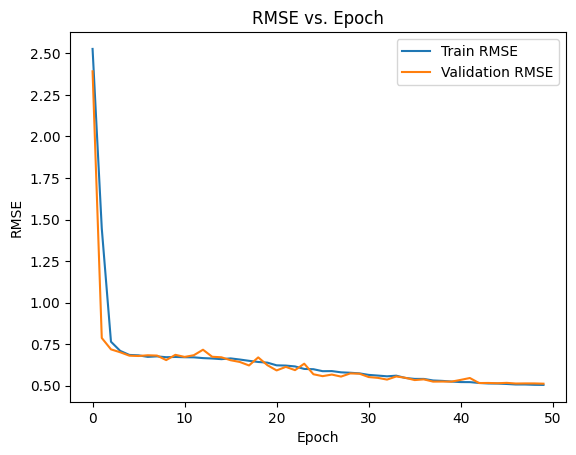

In [28]:
model1_metrics = compile_and_fit(model1, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model1", min_lr=1e-6, max_lr=4e-3, epochs=50)  # Train and evaluate Model1

Successfully created and tested Model2


train_rmse: 4.95e-01 | val_rmse: 5.03e-01: 100%|████████████████████| 70/70 [06:23<00:00,  5.48s/it]



Training completed in 383.65 seconds
Best model found at epoch 66/70
Best Train Loss: 0.2478, Best Val Loss: 0.2514
Best Train MSE: 0.2478, Best Val MSE: 0.2518
Best Train RMSE: 0.4978, Best Val RMSE: 0.5018
Best model saved to models/Regression/california_housing/CNN+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model2/best_model.pth


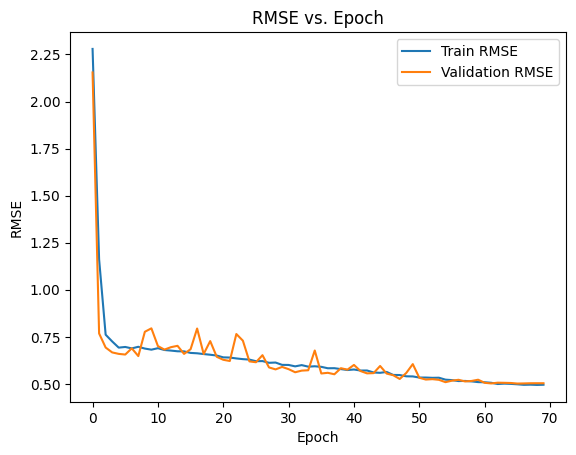

In [45]:
model2 = try_create_model(Model2, attributes, imgs_shape, device)  # Attempt to create Model2
model2_metrics = compile_and_fit(model2, train_loader, val_loader, test_loader, dataset_name, f"{name}_Model2", min_lr=1e-6, max_lr=4e-3, epochs=70)  # Train and evaluate Model1

# TestHibrid

In [58]:
class Model3(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model3, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], 16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.Flatten()
        ).to(device)

        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 12],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

        # Calculate the size of the flattened CNN output
        self.cnn_output_size = 16 * (imgs_shape[1] - 1) * (imgs_shape[2] - 1)

        # Final MLP layers
        self.final_kan = KAN(
            width=[self.cnn_output_size + 12, 1],
            grid=8,
            k=3,
            seed=SEED,
            device=device
        )

        self.device = device

    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [47]:
def combine_loader(loader):
    """
    Combines all batches from a DataLoader into three tensors.
    Assumes each batch is a tuple: (mlp_tensor, img_tensor, target_tensor)
    """
    mlp_list, img_list, target_list = [], [], []
    for mlp, img, target in loader:
        mlp_list.append(mlp)
        img_list.append(img)
        target_list.append(target)
    return torch.cat(mlp_list, dim=0), torch.cat(img_list, dim=0), torch.cat(target_list, dim=0)

In [48]:
# Combine dataloaders into tensors.
train_mlp, train_img, train_target = combine_loader(train_loader)
val_mlp, val_img, val_target = combine_loader(val_loader)
test_mlp, test_img, test_target = combine_loader(test_loader)

dataset = {
    "train_mlp": train_mlp.to(device),
    "train_img": train_img.to(device),
    "train_target": train_target.to(device),
    "val_mlp": val_mlp.to(device),
    "val_img": val_img.to(device),
    "val_target": val_target.to(device),
    "test_mlp": test_mlp.to(device),
    "test_img": test_img.to(device),
    "test_target": test_target.to(device),
}

In [49]:
import os
import time
import copy
import numpy as np
import torch
import torch.optim as optim
from torch.optim import LBFGS
from tqdm import tqdm
import matplotlib.pyplot as plt

def fit_hybrid_dataloaders(model, 
                           dataset,
                           opt="Adam", 
                           steps=100, 
                           log=1, 
                           lamb=0., 
                           lamb_l1=1., 
                           lamb_entropy=2., 
                           lamb_coef=0., 
                           lamb_coefdiff=0., 
                           update_grid=True, 
                           grid_update_num=10, 
                           loss_fn=None, 
                           lr=1., 
                           start_grid_update_step=-1, 
                           stop_grid_update_step=50, 
                           batch=-1,
                           metrics=None, 
                           save_fig=False, 
                           in_vars=None, 
                           out_vars=None, 
                           beta=3, 
                           save_fig_freq=1, 
                           img_folder='./video', 
                           singularity_avoiding=False, 
                           y_th=1000., 
                           reg_metric='edge_forward_spline_n', 
                           display_metrics=None):
    """
    Trains the hybrid model (with a KAN branch and a CNN branch) using a steps-based loop
    adapted from KAN.fit(), with grid updates and regularization.
    
    Instead of a single dataset dict, this function accepts three DataLoaders:
        - train_loader: provides (mlp, img, target) for training
        - val_loader: provides (mlp, img, target) for validation
        - test_loader: provides (mlp, img, target) for evaluation during training

    Internally, the function combines each loader into a dataset dictionary.
    
    Returns:
        results: dictionary containing training loss, evaluation loss, regularization values,
                 and any additional metrics recorded during training.
    """
    device = next(model.parameters()).device

    # Warn if regularization is requested but model's internal flag isn't enabled.
    if lamb > 0. and not getattr(model.m_kan, "save_act", False):
        print("setting lamb=0. If you want to set lamb > 0, set model.m_kan.save_act=True")
    
    # Disable symbolic processing for training if applicable (KAN internal logic)
    if hasattr(model.m_kan, "disable_symbolic_in_fit"):
        old_save_act, old_symbolic_enabled = model.m_kan.disable_symbolic_in_fit(lamb)
    else:
        old_save_act, old_symbolic_enabled = None, None

    pbar = tqdm(range(steps), desc='Training', ncols=100)

    # Default loss function (mean squared error) if not provided
    if loss_fn is None:
        loss_fn = lambda x, y: torch.mean((x - y) ** 2)

    # Determine grid update frequency
    grid_update_freq = int(stop_grid_update_step / grid_update_num) if grid_update_num > 0 else 1

    # Determine total number of training examples
    n_train = dataset["train_mlp"].shape[0]
    n_eval  = dataset["test_mlp"].shape[0]  # using test set for evaluation during training
    batch_size = n_train if batch == -1 or batch > n_train else batch

    # Set up optimizer: choose between Adam and LBFGS (removed tolerance_ys)
    if opt == "Adam":
        optimizer = optim.Adam(model.parameters(), lr=lr)
    elif opt == "LBFGS":
        optimizer = LBFGS(model.parameters(), lr=lr, history_size=10, 
                          line_search_fn="strong_wolfe", 
                          tolerance_grad=1e-32, 
                          tolerance_change=1e-32)
    else:
        raise ValueError("Optimizer not recognized. Use 'Adam' or 'LBFGS'.")

    # Prepare results dictionary.
    results = {
        'train_loss': [],
        'eval_loss': [],
        'val_loss': [],
        'reg': []
    }

    
    if metrics is not None:
        for metric in metrics:
            results[metric.__name__] = []

    for step in pbar:
        # Randomly sample indices for a mini-batch from the training set.
        train_indices = np.random.choice(n_train, batch_size, replace=False)
        # Use full evaluation set for evaluation; you can also sample if desired.
        eval_indices = np.arange(n_eval)

        # Closure for LBFGS
        def closure():
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            # Compute regularization term if enabled.
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    #model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    #model.final_kan.node_attribute()
                reg_val_inner = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
            else:
                reg_val_inner = torch.tensor(0., device=device)
            loss_val_inner = train_loss + lamb * reg_val_inner
            loss_val_inner.backward()
            return loss_val_inner

        # Perform grid update if applicable.
        if (step % grid_update_freq == 0 and step < stop_grid_update_step 
            and update_grid and step >= start_grid_update_step):
            model.m_kan.update_grid(dataset["train_mlp"][train_indices])
            # output = model.get_concat_output(dataset["train_mlp"], dataset["train_img"])
            # model.final_kan.update_grid(output[train_indices])

        # Perform an optimizer step.
        if opt == "LBFGS":
            optimizer.step(closure)
            loss_val = closure()  # re-evaluate to record loss
            # Compute reg_val separately for logging
            with torch.no_grad():
                mlp_batch = dataset["train_mlp"][train_indices]
                img_batch = dataset["train_img"][train_indices]
                target_batch = dataset["train_target"][train_indices]
                outputs = model(mlp_batch, img_batch)
                train_loss = loss_fn(outputs, target_batch)
                if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                    if reg_metric == 'edge_backward':
                        model.m_kan.attribute()
                        #model.final_kan.attribute()
                    if reg_metric == 'node_backward':
                        model.m_kan.node_attribute()
                        #model.final_kan.node_attribute()
                    reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                    #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
                else:
                    reg_val = torch.tensor(0., device=device)
        else:  # Adam branch
            optimizer.zero_grad()
            mlp_batch = dataset["train_mlp"][train_indices]
            img_batch = dataset["train_img"][train_indices]
            target_batch = dataset["train_target"][train_indices]
            outputs = model(mlp_batch, img_batch)
            train_loss = loss_fn(outputs, target_batch)
            if hasattr(model.m_kan, "save_act") and model.m_kan.save_act:
                if reg_metric == 'edge_backward':
                    model.m_kan.attribute()
                    #model.final_kan.attribute()
                if reg_metric == 'node_backward':
                    model.m_kan.node_attribute()
                    #model.final_kan.node_attribute()
                reg_val = model.m_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff)
                #reg_val = (reg_val + model.final_kan.get_reg(reg_metric, lamb_l1, lamb_entropy, lamb_coef, lamb_coefdiff))/2
            else:
                reg_val = torch.tensor(0., device=device)
            loss_val = train_loss + lamb * reg_val
            loss_val.backward()
            optimizer.step()

        # Evaluate on the entire evaluation set (from test_loader)
        mlp_eval = dataset["test_mlp"][eval_indices]
        img_eval = dataset["test_img"][eval_indices]
        target_eval = dataset["test_target"][eval_indices]
        eval_loss = loss_fn(model(mlp_eval, img_eval), target_eval)

        # Record results (using square-root of loss similar to KAN.fit)
        results['train_loss'].append(torch.sqrt(loss_val.detach()).item())
        results['eval_loss'].append(torch.sqrt(eval_loss.detach()).item())
        results['reg'].append(reg_val.detach().item())

        # New: Compute validation loss if validation data exists in the dataset.
        # val_loss = loss_fn(model(dataset['val_mlp'][eval_indices], dataset['val_img'][eval_indices]), dataset['val_target'][eval_indices])
        # results['val_loss'].append(torch.sqrt(val_loss).cpu().detach().numpy())

        if metrics is not None:
            for metric in metrics:
                # Here, we assume each metric returns a tensor.
                results[metric.__name__].append(metric().item())

        # Update progress bar.
        if display_metrics is None:
            pbar.set_description("| train_loss: %.2e | eval_loss: %.2e | reg: %.2e |" %
                                 (torch.sqrt(loss_val.detach()).item(),
                                  torch.sqrt(eval_loss.detach()).item(),
                                  reg_val.detach().item()))
        else:
            desc = ""
            data = []
            for metric in display_metrics:
                desc += f" {metric}: %.2e |"
                data.append(results[metric.__name__][-1])
            pbar.set_description(desc % tuple(data))

        # Optionally save a figure snapshot.
        if save_fig and step % save_fig_freq == 0:
            save_act_backup = getattr(model.m_kan, "save_act", False)
            model.m_kan.save_act = True
            model.plot(folder=img_folder, in_vars=in_vars, out_vars=out_vars, title=f"Step {step}", beta=beta)
            plt.savefig(os.path.join(img_folder, f"{step}.jpg"), bbox_inches='tight', dpi=200)
            plt.close()
            model.m_kan.save_act = save_act_backup

    # Restore original settings if applicable.
    if old_symbolic_enabled is not None:
        model.m_kan.symbolic_enabled = old_symbolic_enabled
    if hasattr(model.m_kan, "log_history"):
        model.m_kan.log_history('fit')

    return results


In [39]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


train_rmse: 6.30e-01 | val_rmse: 6.17e-01: 100%|█████████████████████| 5/5 [18:21<00:00, 220.27s/it]



Training completed in 1101.34 seconds
Best model found at epoch 5/5
Best Train Loss: 0.3970, Best Val Loss: 0.3813
Best Train MSE: 0.3970, Best Val MSE: 0.3811
Best Train RMSE: 0.6301, Best Val RMSE: 0.6173
Best model saved to models/Regression/california_housing/CNN+MLP/IGTD_3x3_fEuclidean_iEuclidean_abs_Model3/best_model.pth


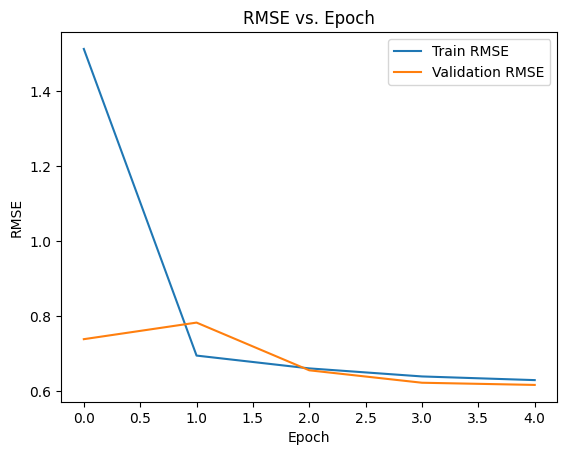

In [40]:
model3_metrics = compile_and_fit(model3, train_loader, val_loader, test_loader, dataset_name, 
                                 f"{name}_Model3", min_lr=1e-6, max_lr=4e-3, epochs=5)  # Train and evaluate Model1

In [50]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders(model3, dataset, opt="Adam", steps=100, lamb=0.,  reg_metric = 'node_backward')

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 8.04e-01 | eval_loss: 8.08e-01 | reg: 0.00e+00 |: 100%|█| 100/100 [00:12<00:00,  7.81i

saving model version 0.1


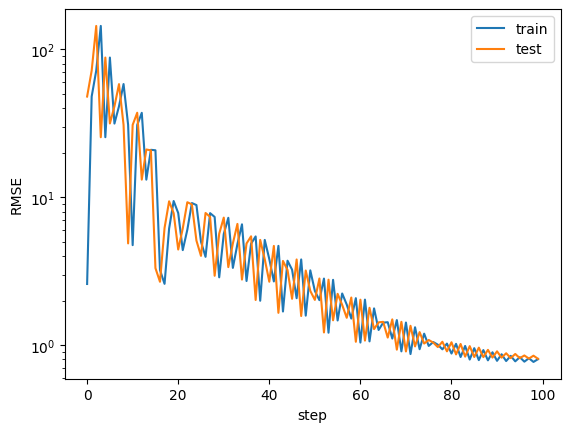

In [51]:
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

In [52]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders(model3, dataset, opt="LBFGS", steps=60)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 4.43e-01 | eval_loss: 5.16e-01 | reg: 0.00e+00 |: 100%|█| 60/60 [02:50<00:00,  2.85s/i

saving model version 0.1


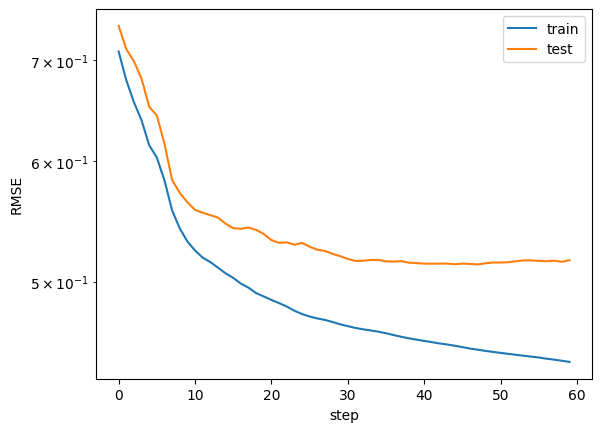

In [53]:
plt.plot(metrics3['train_loss'])
plt.plot(metrics3['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

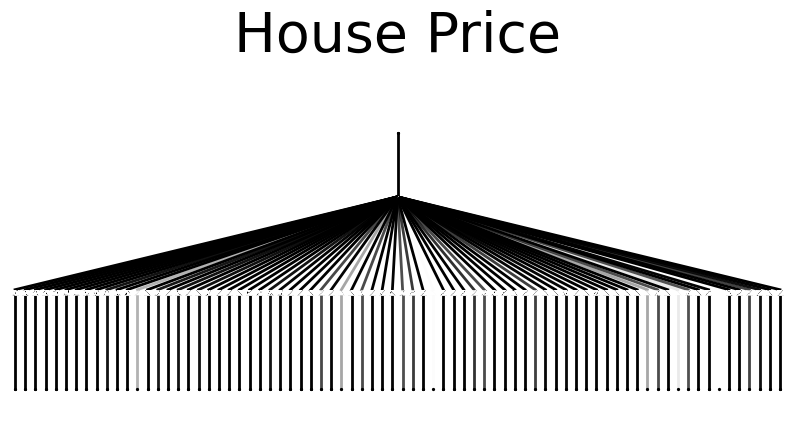

In [55]:
model3.final_kan.plot(beta=50, scale=1, out_vars=['House Price'])

In [96]:
model3 = try_create_model(Model3, attributes, imgs_shape, device)
metrics3 = fit_hybrid_dataloaders(model3, dataset, opt="LBFGS", steps=30, lamb=0.001, lamb_entropy=.01) #0 y 2

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model3


| train_loss: 5.01e-01 | eval_loss: 5.36e-01 | reg: 5.16e+00 |: 100%|█| 30/30 [06:19<00:00, 12.65s/i

saving model version 0.1


In [56]:
model3.final_kan.feature_score

tensor([9.8438e-02, 1.7719e-01, 2.8663e-01, 1.6052e-01, 1.3449e-01, 1.9120e-01,
        3.5585e-01, 2.2053e-01, 9.4523e-02, 3.3086e-02, 1.2367e-01, 2.8299e-01,
        6.2696e-03, 2.3479e-01, 3.0651e-02, 2.5582e-01, 3.3105e-02, 3.5348e-01,
        3.4366e-02, 1.1408e-01, 6.7849e-01, 1.5476e-01, 1.2749e-01, 4.0342e-01,
        4.2830e-01, 3.2327e-02, 4.9158e-02, 5.0874e-01, 1.2970e-01, 1.4240e+00,
        1.8118e-02, 5.2434e-02, 7.2971e-03, 3.0679e-01, 1.7730e-02, 3.1772e-01,
        8.0573e-02, 5.7178e-02, 1.7060e-02, 2.0574e-02, 1.4640e-01, 2.7009e-04,
        7.0415e-02, 2.5133e-01, 7.4472e-01, 2.2406e-02, 1.7747e-02, 7.2089e-02,
        1.0535e-01, 8.5014e-02, 9.8016e-02, 1.9763e-02, 4.6202e-02, 3.0868e-01,
        4.2435e-02, 1.6688e-01, 4.1048e-01, 5.4939e-02, 2.3374e-01, 2.5630e-01,
        1.2508e-01, 3.4448e-01, 7.1955e-03, 1.7473e-02, 6.4518e-02, 1.6517e-03,
        1.6840e-02, 1.7670e-01, 5.0223e-02, 1.8042e-05, 7.5781e-02, 2.5084e-01,
        1.8924e-02, 3.4839e-02, 5.2877e-

In [59]:
class Model4(nn.Module):
    def __init__(self, attributes, imgs_shape, device):
        super(Model4, self).__init__()
        # CNN branch
        self.cnn_branch = nn.Sequential(
            nn.Conv2d(imgs_shape[0], out_channels=16, kernel_size=2),
            nn.BatchNorm2d(16),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(16, 32, kernel_size=2, padding=1),
            nn.BatchNorm2d(32),
            nn.ReLU(),
            nn.Conv2d(32, 64, kernel_size=2, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2, 2),
            nn.Conv2d(64, 16, kernel_size=2, padding=1),
            nn.Flatten()
        ).to(device)
        # Final KAN layers
        self.m_kan = KAN(
            width=[attributes, 12],
            grid=8,
            k=3
        )
        # Final MLP layers
        self.final_kan = KAN(
            width=[self.flat_size + 12, 1],
            grid=8,
            k=3
        )

        self.device = device
       
        # Calculate the size of the flattened output
        self.flat_size = self._get_flat_size(imgs_shape)
        

    def _get_flat_size(self, imgs_shape):
        # Forward pass with dummy input to calculate flat size
        dummy_input = torch.zeros(4, *imgs_shape, device=device)
        x = self.cnn_branch(dummy_input)
        return x.size(1)


    def get_concat_output(self, mlp_input, cnn_input):
        # Ensure inputs are moved to the correct device
        kan_input = mlp_input.to(self.device)
        cnn_input = cnn_input.to(self.device)
        
        cnn_output = self.cnn_branch(cnn_input)  # Process image input
        kan_output = self.m_kan(kan_input)  # Process numerical input
        
        return torch.cat((kan_output, cnn_output), dim=1)

    
    def forward(self, mlp_input, cnn_input):
        concat_output = self.get_concat_output(mlp_input, cnn_input)
        return self.final_kan(concat_output)

In [68]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders(model4, dataset, opt="Adam", steps=80)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 2.51e+00 | eval_loss: 2.04e+00 | reg: 0.00e+00 |: 100%|█| 80/80 [00:11<00:00,  7.13it/

saving model version 0.1


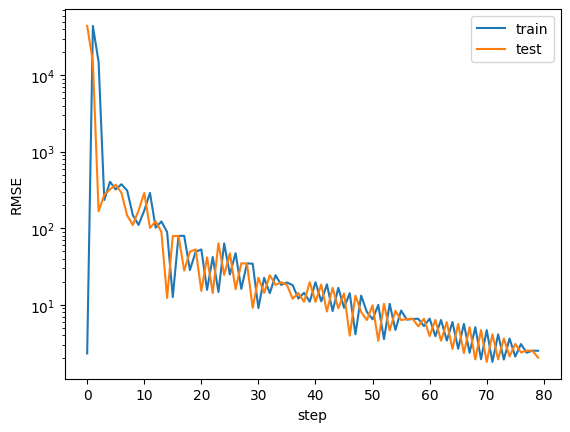

In [69]:
plt.plot(metrics4['train_loss'])
plt.plot(metrics4['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

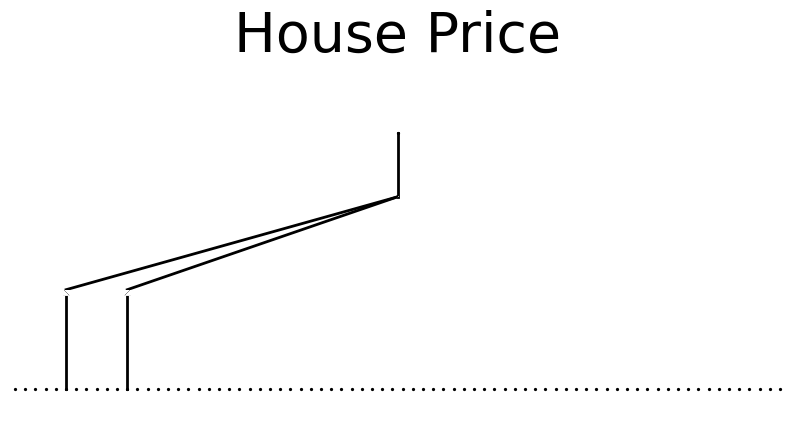

In [70]:
model4.final_kan.plot(beta=50, scale=1, out_vars=['House Price'])

In [71]:
model4.final_kan.feature_score

tensor([0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 4.8362e+00,
        0.0000e+00, 2.9629e-06, 2.9962e-14, 0.0000e+00, 0.0000e+00, 5.0124e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00, 0.0000e+00,
        0.0000e+00, 0.0000e+00, 0.0000e+

In [74]:
model4 = try_create_model(Model4, attributes, imgs_shape, device)
metrics4 = fit_hybrid_dataloaders(model4, dataset, opt="LBFGS", steps=30)

checkpoint directory created: ./model
saving model version 0.0
checkpoint directory created: ./model
saving model version 0.0
Successfully created and tested Model4


| train_loss: 4.71e-01 | eval_loss: 5.22e-01 | reg: 0.00e+00 |: 100%|█| 30/30 [01:27<00:00,  2.91s/i

saving model version 0.1


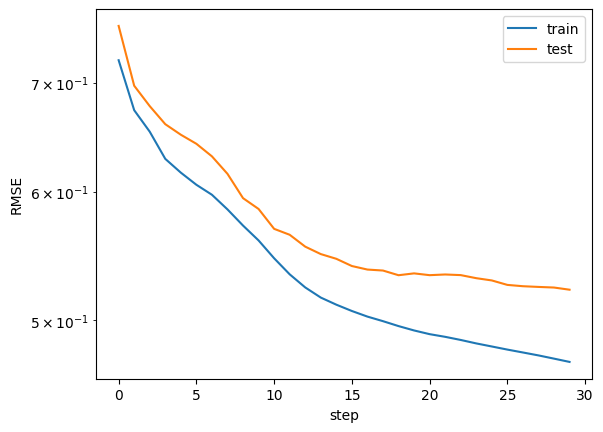

In [75]:
plt.plot(metrics4['train_loss'])
plt.plot(metrics4['eval_loss'])
plt.legend(['train', 'test'])
plt.ylabel('RMSE')
plt.xlabel('step')
plt.yscale('log')

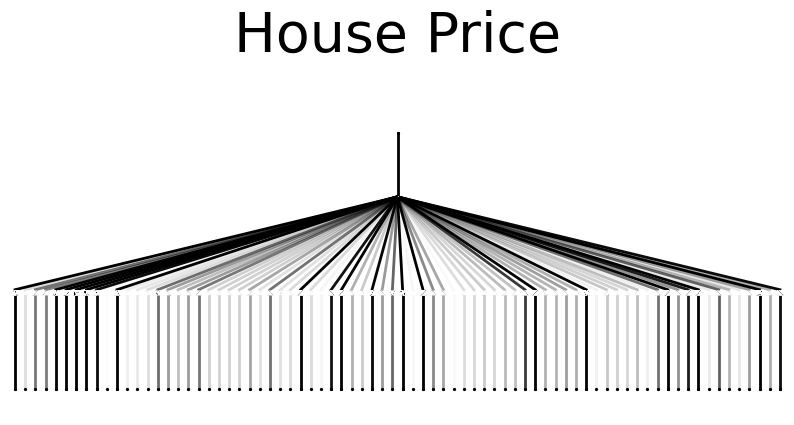

In [79]:
model4.final_kan.plot(beta=50, scale=1, out_vars=['House Price'])

In [80]:
model4.final_kan.feature_score

tensor([8.0416e-02, 2.5680e-03, 1.1885e-02, 1.1234e-02, 4.8300e-02, 2.5985e-01,
        3.3108e-01, 2.3868e-01, 3.7799e-02, 2.0695e-04, 5.5599e-02, 1.3066e-03,
        1.8559e-03, 2.7110e-03, 1.3041e-02, 8.2254e-03, 5.1020e-03, 8.1382e-03,
        1.1845e-02, 3.7485e-03, 3.6350e-03, 3.6474e-03, 3.7482e-03, 7.2781e-03,
        2.3615e-03, 1.2468e-02, 2.3655e-03, 2.9595e-03, 2.0569e-01, 2.9471e-03,
        7.7875e-04, 3.3206e-02, 7.3492e-02, 6.4176e-03, 4.1154e-03, 4.4840e-02,
        8.2918e-03, 1.3839e-02, 7.2391e-02, 6.4900e-04, 1.8325e-01, 1.0057e-02,
        7.2113e-03, 4.8360e-04, 2.6524e-03, 3.1088e-03, 4.1919e-03, 3.2050e-03,
        5.4736e-03, 4.9835e-03, 2.0554e-02, 5.7453e-02, 6.2504e-03, 6.0978e-03,
        7.9056e-03, 6.4793e-03, 6.7457e-02, 1.0864e-03, 4.4320e-03, 3.7323e-03,
        3.2432e-03, 5.1822e-03, 1.2601e-03, 1.2439e-02, 6.3205e-02, 9.0741e-03,
        2.8311e-02, 8.2243e-02, 1.5550e-03, 1.4298e-02, 5.8478e-03, 1.8806e-03,
        8.0154e-03, 7.9747e-02, 6.5543e-

# Show symbolic formula generated

In [125]:
lib = ['x','x^2','x^3','x^4','exp','log','sqrt','tanh','sin','tan','abs']
model.auto_symbolic(lib=lib)
formula = model.symbolic_formula()[0][0]
ex_round(formula, 4)

fixing (0,0,0) with x, r2=0.9765904545783997, c=1
fixing (0,0,1) with x, r2=0.680465817451477, c=1
fixing (0,0,2) with x, r2=0.30162280797958374, c=1
fixing (0,0,3) with x, r2=0.7910828590393066, c=1
fixing (0,0,4) with x, r2=0.7882108688354492, c=1
fixing (0,0,5) with x, r2=0.9033933877944946, c=1
fixing (0,0,6) with x, r2=0.8512812852859497, c=1
fixing (0,0,7) with sin, r2=0.9786099195480347, c=2
fixing (0,0,8) with x, r2=0.7940358519554138, c=1
fixing (0,0,9) with x, r2=0.8807955384254456, c=1
fixing (0,0,10) with sin, r2=0.9662820100784302, c=2
fixing (0,0,11) with x, r2=0.9679688811302185, c=1
fixing (0,1,0) with x, r2=0.8030456900596619, c=1
fixing (0,1,1) with x, r2=0.8620676398277283, c=1
fixing (0,1,2) with x, r2=0.8049867153167725, c=1
fixing (0,1,3) with x, r2=0.8315892219543457, c=1
fixing (0,1,4) with sin, r2=0.9514980912208557, c=2
fixing (0,1,5) with x, r2=0.1296408772468567, c=1
fixing (0,1,6) with x, r2=0.36357271671295166, c=1
fixing (0,1,7) with x, r2=0.8230635523796

0.3431*x_1 - 0.0797*x_2 + 0.2743*x_3 - 0.0964*x_4 - 0.003*x_5 - 0.0562*x_6 - 0.5932*x_7 - 0.4589*x_8 - 0.0356*sin(0.5831*x_1 + 7.0167) - 0.0015*sin(1.7178*x_2 - 1.7947) + 0.0006*sin(1.8226*x_6 + 1.8284) + 0.0428*sin(2.6116*x_6 - 1.4098) + 0.0018*sin(2.6193*x_6 + 1.5833) + 0.0642*sin(2.994*x_6 - 7.5881) - 0.1204*sin(3.3682*x_6 + 4.9941) + 0.0067*sin(3.405*x_6 - 7.5914) + 0.0204*sin(3.9885*x_6 + 5.0028) + 0.0742*sin(5.0002*x_6 + 5.0027) + 1.715

# Show Feature Importance

In [126]:
model.feature_score

tensor([0.7730, 0.3418, 0.4180, 0.3838, 0.1135, 0.5291, 1.6611, 1.4451],
       device='cuda:0', grad_fn=<MeanBackward1>)